# Colour - HDRI - Examples: Adobe DNG SDK Colour Processing

Through this example, some Canon EOS 5D Mark II *CR2* files will be white balanced using *Colour - HDRI* *Adobe DNG SDK* colour processing.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- White balancing of the intermediate *Tiff* files using *Adobe DNG SDK* colour processing:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
    - White balancing of the intermediate *Tiff* files.
    - Conversion of the intermediate *Tiff* files to *RGB* display colourspace.
- Display of the final resulting images.

## CR2 File Conversion to DNG and Intermediate File

In [1]:
import logging
import numpy as np
import os

import colour
from colour.plotting import *

from colour_hdri import (
    EXAMPLES_RESOURCES_DIRECTORY,
    camera_neutral_to_xy,
    camera_space_to_XYZ_matrix,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_dng_files_exif_tags,
    highlights_recovery_LCHab,
    update_exif_tags)
from colour_hdri.models import (
    CCS_ILLUMINANT_ADOBEDNG,
    CCT_ILLUMINANTS_ADOBEDNG,
    LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS)

logging.basicConfig(level=logging.INFO)

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'frobisher_001')

colour.utilities.filter_warnings()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.4 (default, Sep  7 2019, 18:27:02)                       *
*                [Clang 10.0.1 (clang-1001.0.46.4)]                           *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.14                                                       *
*       colour-hdri : v0.1.5-60-g9648d86                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.6.1                                                       *
*       matplotlib : 3.0.3                                                    *
*       numpy : 1.17.3                  

In [2]:
colour_style();

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=True)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" file.
INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" file.
INFO:colour_hdri.process.dng:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples

1

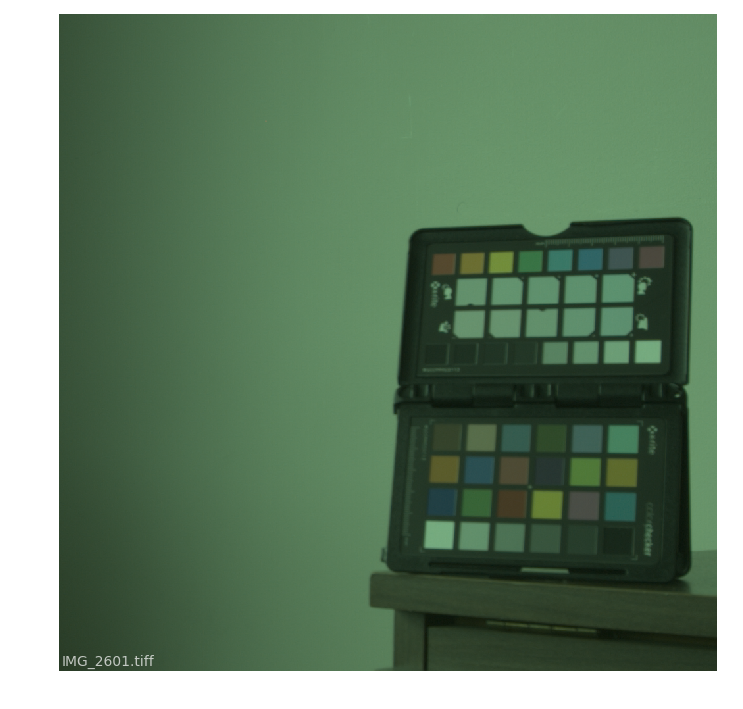

In [4]:
plot_image(colour.cctf_encoding(colour.read_image(
            str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           {'text': os.path.basename(INTERMEDIATE_FILES[-2])});

## Adobe DNG SDK Colour Processing

In [5]:
def process_raw_files(
        dng_files,
        output_directory):
    paths = []
    for dng_file in dng_files:
        exif_tags = read_dng_files_exif_tags((dng_file, ))[0]
        
        exif_group = exif_tags['EXIF']
        CCT_calibration_illuminant_1 = (
            CCT_ILLUMINANTS_ADOBEDNG[
                LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[
                    exif_group['Calibration Illuminant 1']]])
        CCT_calibration_illuminant_2 = (
            CCT_ILLUMINANTS_ADOBEDNG[
                LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[
                    exif_group['Calibration Illuminant 2']]])
        M_color_matrix_1 = exif_group['Color Matrix 1']
        M_color_matrix_2 = exif_group['Color Matrix 2']
        M_camera_calibration_1 = exif_group['Camera Calibration 1']
        M_camera_calibration_2 = exif_group['Camera Calibration 2']
        analog_balance = exif_group['Analog Balance']
        M_forward_matrix_1 = exif_group['Forward Matrix 1']
        M_forward_matrix_2 = exif_group['Forward Matrix 2']
        as_shot_neutral = exif_group['As Shot Neutral']
        
        logging.info('"As Shot Neutral": "{0}"...'.format(as_shot_neutral))
        xy = camera_neutral_to_xy(
            as_shot_neutral,
            CCT_calibration_illuminant_1,
            CCT_calibration_illuminant_2,
            M_color_matrix_1,
            M_color_matrix_2,
            M_camera_calibration_1,
            M_camera_calibration_2,
            analog_balance)
        
        M_camera_space_to_XYZ = camera_space_to_XYZ_matrix(
            xy,
            CCT_calibration_illuminant_1,
            CCT_calibration_illuminant_2,
            M_color_matrix_1,
            M_color_matrix_2,
            M_camera_calibration_1,
            M_camera_calibration_2,
            analog_balance,
            M_forward_matrix_1,
            M_forward_matrix_2)

        logging.info('"Camera Space to XYZ": "{0}"...'.format(M_camera_space_to_XYZ))
        
        path = str(dng_file.replace('dng', 'tiff'))
        image = colour.read_image(path)

        image = colour.utilities.dot_vector(M_camera_space_to_XYZ, image)
        image = colour.XYZ_to_sRGB(
            image, CCS_ILLUMINANT_ADOBEDNG, apply_cctf_encoding=False)

        path = os.path.join(
            output_directory,
            '{0}.{1}'.format(
                os.path.splitext(os.path.basename(path))[0],
                'exr'))
        paths.append(path)
        
        logging.info('Recovering highlights...')
        # NOTE: In some edge cases, the threshold for highlights 
        # recovery can be negative because of out of gamut values.
        # For such cases you can perform the recovery in a larger
        # RGB colourspace such as *ACES 2065-1* or *Xtreme RGB*.         
        XYZ_t = colour.utilities.dot_vector(M_camera_space_to_XYZ, np.ones(3))
        RGB_t = colour.XYZ_to_sRGB(
            XYZ_t, CCS_ILLUMINANT_ADOBEDNG, apply_cctf_encoding=False)
        image = highlights_recovery_LCHab(image, RGB_t[1])
        
        logging.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

    return paths


PATHS = process_raw_files(DNG_FILES, RESOURCES_DIRECTORY)

INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng' image exif data.
INFO:root:"As Shot Neutral": "[ 0.41307   1.        0.646465]"...
INFO:root:"Camera Space to XYZ": "[[ 2.16040865 -0.1041      0.27224985]
 [ 1.05333236  0.6621     -0.15035617]
 [ 0.12225531 -0.1562      1.43983046]]"...
INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.exr"...
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng' image exif data.
INFO:root:"As Shot Neutral": "[ 0.41307   1.        0.646465]"...
INFO:root:"Camera Space to XYZ": "[[ 2.16040865 -0.1041      0.27224985]
 [ 1.05333236  0.6621     -0

## Image Display

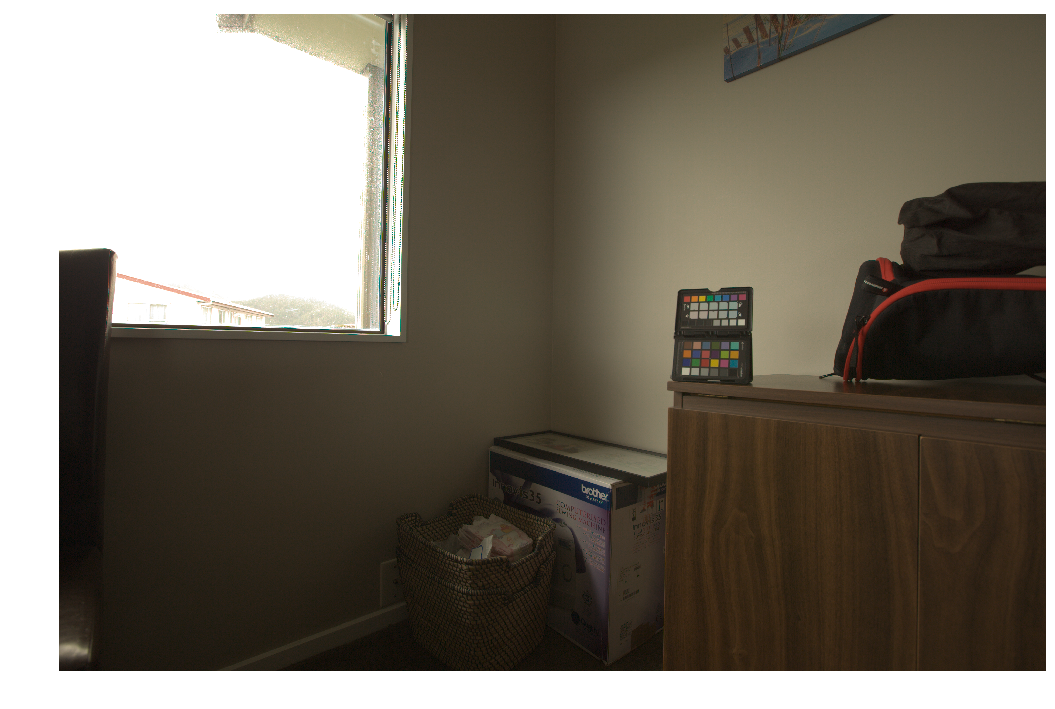

In [6]:
plot_image(colour.cctf_encoding(colour.read_image(PATHS[-2])));